In [9]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [10]:
%%html
<a href="Intro.html" target="_self"><font size="5">Introduction</font></a>&nbsp&nbsp&nbsp
<a href="MF.html" target="_self"><font size="5">Matrix Factorization</font></a>&nbsp&nbsp&nbsp
<a href="HB.html" target="_self"><font size="5">Hybrid Model</font></a>&nbsp&nbsp&nbsp
<a href="Con.html" target="_self"><font size="5">Conclusion</font></a>&nbsp&nbsp&nbsp

# Collaborative Filtering for Recommender Systems

## Introduction

- [1.1 Our Model](#Our-Model)
- [1.2 Data cleaning](#Data-cleaning-:)
- [1.3 Model](#Model)
- [1.4 User Based Recommendation](#User-Based-Recommendation)
- [1.5 Other models for recommender systems](#Other-models-for-recommender-systems)

Collaborative filtering models are of two categories- *neighbourhood based*(which uses user-user interaction or movie similarity) models and *latent feature* based models(which uses matrix factorization).
In case of collaborative filtering(neighbourhood-based) model, we use user history and movie similarity to predict ratings for a movie. There is no additional information required to create a profile for a user since the user history is determined based on user ratings on movies he has rated. Collaborative filtering systems(neighbourhood based) incorporates the ratings and reviews of each user to build a similarity matrix between users. Then, using the k-nearest neighbors approach, the system predicts the rating that a particular user would assign to a given item based on his or her similarity measure between other uses in the dataset. Heuristically, collaborative filtering employs the wisdom of the crowd, making use of more information available from our given dataset. Matrix factorization model is described later.

An important issue to consider in collaborative filtering systems(neighbourhood based) is what similarity measure to use. "Baseline" measures of similarity should be able to assign low similarity scores between two users who have drastically different ratings on every item that they rate in common. Good measures of similarity should furthermore be sensitive enough to assign low similarity scores between users who have similar ratings for a sizable portion of items that they rate in common, but with completely opposite ratings for select few items. Two common measures of similarity are the *Jaccard similarity* and the *cosine similarity*.

We now sketch a mathematical framework for collaborative filtering(neighbourhood based) before proceeding with a dicussion of our modeling choices and procedures. In a typical recommender system scenario, we have 

1. a set of users $(a, b, c, \cdots )$ 
2. a set of movies $(i, j, k, \cdots)$
3. movie ratings assigned by some user $a$ on some movie $i$, denoted as $Y_{ai} \in \mathbb{R}$

We then compute the similarities $K(a, b)$ between all pair-wise combinations from the set of users using some similarity measure listed earlier. 

Now, suppose user $a$ has not rated movie $i$. Denote $kNN(a, i)$ to be the set consisting of the $k$ users who are nearest in similarity to user $a$ who have rated movie $i$. Then, the predicted rating that user $a$ assigns to movie $i$, $Y_{ai}$, can be computed as
\begin{equation*}
\hat{Y}_{ai} = \bar{Y}_a + \frac{\sum_{b \in kNN(a, i)} K(a, b) \cdot (Y_{bi} - \bar{Y}_b)}{\sum_{b \in kNN(a, i)} |K(a, b)|}
\end{equation*}
where $\bar{Y}_a$ and $\bar{Y}_b$ are the mean of all ratings given by users $a$ and $b$, respectively. This mean-controlling procedure serves to "dampen" the effects of excessively generous or excessively harsh users.



## Our Model
We employ a specific form of collaborative filtering known as _item-based collaborative filtering_ to assign ratings that each reviewer in our dataset would give to a movie that he or she had not rated. Item-based collaborative filtering consists of computing the similarities between movies based on the ratings given by reviewers. We also incorporate _user-based filtering_, which extends item-based filtering by including user consumption histories as well. Item-based and user-based filtering are illustrated in the figure below (image taken from http://www.salemmarafi.com/code/collaborative-filtering-r/):

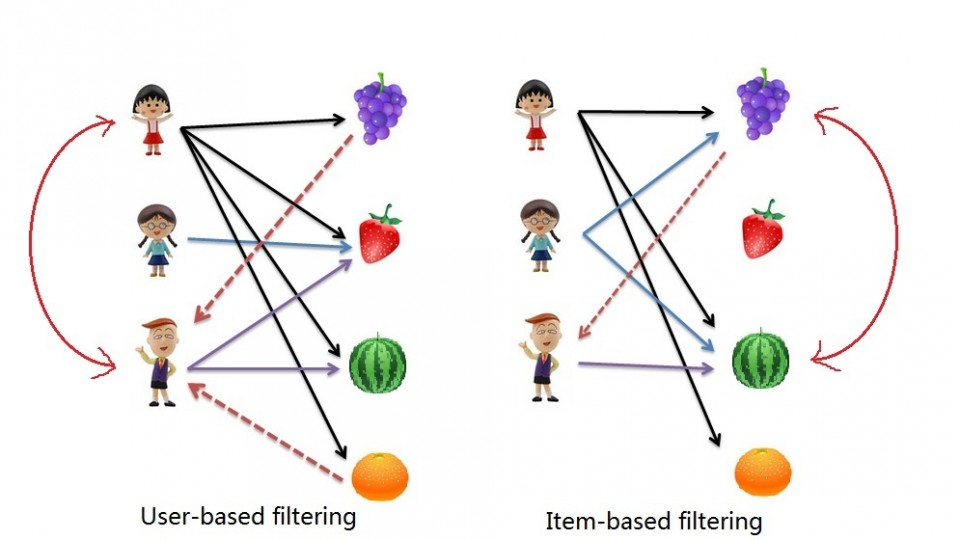

In [86]:
from IPython.display import Image
from IPython.display import display
x = Image(filename='collab_filtering.jpg', width = 500, height = 500) 
display(x)

Again, in item-based filtering (top right figure), if two movies are rated similarly (grapes and watermelons in the diagram), then if some user $a$ rates watermelons highly but has not rated grapes, we will likely recommend grapes to $a$.


In user-based filtering (top left figure), if we find that two users $a$ and $b$ are similar based on profiles constructed from their purchase histories, then if $a$ has consumed some movie $i$ and $b$ has not consumed movie$i$, then there is a high chance that the algorithm system will recomment movie $i$ to $b$.

We present our code and results in the subsequent section.

The dataset we use for matrix factorization is compressed dataset with 3 columns: movieID, revirewerID and rating.
Here is the sample of the dataset.

In [1]:
# importing required modules
import pandas as pd
from scipy.spatial.distance import cosine
import numpy as np

In [2]:
# The dataset we use for user collaborative filtering is compressed dataset with 3 columns: movieID, revirewerID 
# and rating.
# Here is the sample of the dataset.
data = pd.read_csv('subset.csv')[["movieID", "reviewerID", "rating"]]
data.head()

,movieID,reviewerID,rating
0,0005019281,ADZPIG9QOCDG5,4.0
1,0005019281,A35947ZP82G7JH,3.0
2,0005019281,A3UORV8A9D5L2E,3.0
3,0005019281,A1VKW06X1O2X7V,5.0
4,0005019281,A3R27T4HADWFFJ,4.0


In [4]:
# no. of entries in the dataset 
print "The shape of the dataset ", data.shape

The shape of the dataset  (1697533, 3)


## Data cleaning :

Since the dataset we have has 1.6 million entries, its difficult to train our model with this huge dataset on local machines. Moreover, there are many users who have rated few movies (say 3 or less). Similarly, there are movies that have been rated by very users (say 3 or less). So we select top 1000 users who have rated the maximum no. of movies and select top 1000 movies rated my top users.

In [5]:
# grouping the data by reviewerID
data_order = data.groupby('reviewerID').count()
# selecting top 1000 users
data_order = data_order.sort_values('movieID',ascending=False)
data_order.head(n=1000)
data_order.index[:1000].values
users_selected = data_order.index[:1000].values
data_users_selected = data[data['reviewerID'].isin(users_selected)]
print "The shape of the reduced dataset ", data_users_selected.shape

The shape of the reduced dataset  (317908, 3)


In [6]:
# selecting most rated movies
# grouping the data by movieID
data_order2 = data.groupby('movieID').count()
data_order2 = data_order2.sort_values('reviewerID',ascending=False)
data_order2.head(n=1000)
data_order2.index[:1000].values
movies_selected = data_order2.index[:1000].values

data_users_selected = data[data['reviewerID'].isin(users_selected)]
data_movies_users_selected = data_users_selected[data['movieID'].isin(movies_selected)]

print "The shape of the reduced dataset ", data_movies_users_selected.shape
data_movies_users_selected.head()

The shape of the reduced dataset  (61542, 3)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,movieID,reviewerID,rating
522,0310263662,A3EE0H0NWQ9QVL,5.0
526,0310263662,A32JKNQ6BABMQ2,3.0
531,0310263662,A1VQBHHXIKHIGS,1.0
535,0310263662,A2PV6GK1HV54Y9,4.0
540,0310263662,A1GSR7RGCG1QYZ,3.0


In [7]:
# further cleaning 
# removing from top 1000 users who have rated less than 3 movies

#grouping by reviewerID
grouped = data_movies_users_selected.groupby('reviewerID')
users = []
for user in data_movies_users_selected['reviewerID'].unique():
    if grouped.get_group(user).shape[0] < 3: 
        users.append(user)

criterion = data_movies_users_selected['reviewerID'].map(lambda x: x not in users)
data_movies_users_selected_new = data_movies_users_selected[criterion]
print "The shape of the final dataset used in training ",  data_movies_users_selected_new.shape

The shape of the final dataset used in training  (61525, 3)


## Model

The data we have cannot be divided into training and testing data by randomly dividing some users as training data and rest of them as testing data, since to predict movies for a user, we need to have some user history. So we create a copy of the original data and mask some of ratings given by user as empty. Then we build a model using the masked dataset and try to predict the recommendation score for the missing entry. We select a threshold value of recommendation score above which the movie is expected to be rated high(4,5) by user, otherwise, the user would rate the movie low(1,2). 

There is no one perfect way of finding the accuracy of a collaborative model for recommender systems. This model is just used to recommend movies to the user which are expected to be rated high by him/her. But for the purpose of our project, we calculate the score of the masked entry and recommend that movie to user if the score is above threshold. If the movie is recommended and the user has actually rated that movie high(4,5 in the unmasked dataset), we add 1 to the accuracy of the model else 0. The total accuracy is defined as the mean value of accuracy for all the missing entries.

Creating matrix of users and movies where each cell represents rating given by the user in the row to the movie in the column

In [8]:
#test data , will randomly mark rating of one movie for each user as NaN and then predict it
data_movies_users_selected_new_test = data_movies_users_selected_new.copy()

In [9]:
# creating matrix of users and movies where each cell represents rating given by  
# the user in the row to the movie in the column
rp_original = data_movies_users_selected_new.pivot_table(columns=['movieID'],index=['reviewerID'],values='rating')
rp_original.head(n= 10)
# NaN represents empty values

movieID,0310263662,0767002652,076780192X,0767802470,0767802519,0767802624,0767802659,0767805267,0767811100,0767824571,...,B00H9KKGTO,B00H9L26AA,B00HEPC0TS,B00HEPDGKA,B00HEPE6MM,B00HHYF570,B00HLTD3ZW,B00HNGZHDE,B00JA3RPAG,B00JAQJMJ0
reviewerID,,,,,,,,,,,,,,,,,,,,,
A10175AMUHOQC4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103KNDW8GN92L,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A106016KSI0YQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A106YXO3EHVD3J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,3.0,3.0,NaN,NaN,NaN
A10H47FMW8NHII,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,5.0,4.0,NaN,4.0,NaN,4.0,4.0,NaN,5.0
A10ODC971MDHV8,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10Q8NIFOVOHFV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11ED8O95W2103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A11PTCZ2FM2547,3.0,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Movie similarity matrix

In [13]:
# creating movie similarity matrix: 
# creating an empty pandas dataframe where the columns and indices are movies
movie_similarity = pd.DataFrame(index=rp.columns,columns=rp.columns)


In [14]:
# similarity between movies
for i in range(0,len(movie_similarity.columns)) :
    # Loop through the columns for each column
    for j in range(0,len(movie_similarity.columns)) :
    #Fill in placeholder with cosine similarities
      movie_similarity.ix[i,j] = 1-cosine(rp.ix[:,i],rp.ix[:,j])

In [16]:
# filling  (NaN) entries in movie similarity matrix with 0.
data_ibs_save = movie_similarity.copy()
movie_similarity = movie_similarity.fillna(0)
movie_similarity.head(n = 10)

movieID,0310263662,0767002652,076780192X,0767802470,0767802519,0767802624,0767802659,0767805267,0767811100,0767824571,...,B00H9KKGTO,B00H9L26AA,B00HEPC0TS,B00HEPDGKA,B00HEPE6MM,B00HHYF570,B00HLTD3ZW,B00HNGZHDE,B00JA3RPAG,B00JAQJMJ0
movieID,,,,,,,,,,,,,,,,,,,,,
0310263662,1.000000,0.024211,0.185505,0.149078,0.128363,0.116532,0.134595,0.180857,0.097302,0.152350,...,0.084795,0.059799,0.035803,0.017289,0.056534,0.034790,0.066257,0.022836,0.000000,0
0767002652,0.024211,1.000000,0.000000,0.046959,0.000000,0.000000,0.043544,0.023168,0.000000,0.038391,...,0.043226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
076780192X,0.185505,0.000000,1.000000,0.270735,0.127124,0.198923,0.175901,0.251918,0.240878,0.222069,...,0.049187,0.063016,0.024341,0.000000,0.018331,0.000000,0.000000,0.000000,0.057438,0
0767802470,0.149078,0.046959,0.270735,1.000000,0.157934,0.111026,0.109437,0.133438,0.059911,0.148749,...,0.048283,0.024743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063430,0
0767802519,0.128363,0.000000,0.127124,0.157934,1.000000,0.061908,0.037630,0.147004,0.200436,0.103116,...,0.088843,0.000000,0.039969,0.059831,0.037625,0.000000,0.000000,0.000000,0.000000,0
0767802624,0.116532,0.000000,0.198923,0.111026,0.061908,1.000000,0.203151,0.154879,0.187606,0.157227,...,0.048667,0.062350,0.021676,0.027039,0.034007,0.054411,0.000000,0.000000,0.063935,0
0767802659,0.134595,0.043544,0.175901,0.109437,0.037630,0.203151,1.000000,0.134047,0.049074,0.105314,...,0.051768,0.026887,0.041543,0.041459,0.031285,0.078214,0.029303,0.054761,0.142143,0
0767805267,0.180857,0.023168,0.251918,0.133438,0.147004,0.154879,0.134047,1.000000,0.069792,0.081820,...,0.055832,0.000000,0.036840,0.068014,0.034679,0.000000,0.000000,0.000000,0.065198,0
0767811100,0.097302,0.000000,0.240878,0.059911,0.200436,0.187606,0.049074,0.069792,1.000000,0.153473,...,0.093140,0.056523,0.036389,0.045393,0.021923,0.000000,0.020533,0.028780,0.051520,0


In [17]:
# Create a placeholder items for closes neighbours to a movie
data_neighbours = pd.DataFrame(index=movie_similarity.columns,columns=range(1,500))
# for each movie, we save 500 nearest movies(500 movies is a large number but we choose it since original
# data is very sparse)
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(movie_similarity.columns)):
    data_neighbours.ix[i,:] = movie_similarity.ix[:,i].sort_values(ascending=False)[1:500].index


Matrix showing 10 nearest neighbours for each movie

In [18]:
# Matrix showing nearest neighbours for movies
data_neighbours.head()

,1,2,3,4,5,6,7,8,9,10,...,490,491,492,493,494,495,496,497,498,499
movieID,,,,,,,,,,,,,,,,,,,,,
0310263662,B00005JMQW,B00005JNJV,B00005JND5,B0002Z0EXQ,B00005JLXH,B00005JKZY,B0002234LS,B0001JXOUS,B00005JN2Z,B00005JMEW,...,0792845730,B00005ALS0,B00005JL3A,B000N4SHOE,156219464X,B00003CXPJ,0788821075,1424810248,B0067EKYS6,B00005AAA9
0767002652,B002VWOMZ4,B00395ATT0,B003WE9C5U,B00FPPQYXM,B000A6T1X6,B004NSUXHU,1608838137,B000CEXG0U,B007T40F14,B001O4C6NA,...,B00005JMFQ,6302035058,6302038308,6300274268,6300989003,B008KEQM3W,B008JFUOWM,B008JFUS8M,6301966988,6301442962
076780192X,1417065818,0783216084,6302760046,0783219695,B00003CWT6,0790705141,630573240X,6305169187,6300247171,B00005JL78,...,B00004XPPG,B0001Z52RU,B00005JNEI,0783241542,B004LWZWFQ,B005S9ELM6,B00009OOFA,B000VWYJ86,B000VIRD6U,6305669651
0767802470,6300214826,076780192X,6300183513,0800132009,0790729644,0790729628,6300216500,0800141709,0780623134,0790743132,...,B00003CXRM,0790743507,B00005JM02,B0001ZX0OC,B000Q6GUT8,B0002JJBZE,B00005ALS0,B008JFUNHI,B004LWZW42,B0059XTU1S
0767802519,0767830520,0783211856,0800137884,B00003CXZ3,0790729644,6304214502,0790701251,0783216084,B00003CXPJ,6304994540,...,B00006AL1D,B002ZG99N6,6302526574,6304117752,6301773551,6305132666,B00BEIYSL4,B001GCUO0C,B00005JPH2,B005LAIIHG


# User Based Recommendation

Part1: Following is the implementation of user based recommendation:
For each user, we get a list of movies sorted in decreasing order by a score. The score for a movie is calculated by taking weighted average of user ratings for nearest neighbours of a movie. The weights user are movie-similarity score. For each user, we recommend top 10 movies with the highest scores.

In [19]:
# --- Start User Based Recommendations --- #
 
# Helper function to get similarity scores
# We use user history and similarity score(as a weight to user rating) to get the final score 
# for a movie to be recommended.
def getScore(history, similarities):
    score = history*similarities
    # to deal with NaN values
    score = score.fillna(0).values
    return sum(score)/sum(similarities)

In [63]:
#Loop through all rows, fill with similarity scores for the movies that have not been rated by user
# loop through each of the user in outer loop
for i in range(0,len(recommended_movie_matrix.index)):
    #loop through each of the movie  in inner loop
    for j in range(1,len(recommended_movie_matrix.columns)):
        #arbitrarily define the user as the index number here
        user = recommended_movie_matrix.index[i]
        # loop through the movie
        movie = recommended_movie_matrix.columns[j]
         # if the user has rated it , recommendation score is 0
        if recommended_movie_matrix.ix[i][j] != 0:
            recommended_movie_matrix.ix[i][j] =0
        
        movie_top_names = data_neighbours.ix[movie]
        movie_top_sims = movie_similarity.ix[movie].sort_values(ascending=False)[1:10]
        user_ratings = rp.ix[user,movie_top_names]
             # get score( history, similarities)
        recommended_movie_matrix.ix[i][j] = getScore(user_ratings,movie_top_sims)




In [55]:
# Get the top movies
data_recommend = pd.DataFrame(columns=['user','1','2','3','4','5','6'])
data_recommend.ix[:,0] = recommended_movie_matrix.ix[:,0]


## Recommended Movies for each user

In [58]:
for i in range(0,len(recommended_movie_matrix.index)):
    # extract the top 6 scores, then obtain the top 6 movie names
    data_recommend.ix[i,1:] = recommended_movie_matrix.ix[i,:].sort_values(ascending=False).ix[1:7,].index.transpose()
data_recommend[['1','2','3','4','5','6']].head()

,1,2,3,4,5,6
reviewerID,,,,,,
A10175AMUHOQC4,B001GCUNZI,B001IDZLCK,B001OQCV2E,B0016Q2D5M,B00JA3RPAG,B00005JKMY
A103KNDW8GN92L,B0001GOH6Q,B00005JMEW,6300989003,0784010315,0790741105,B00005JKC3
A106016KSI0YQ,6303965415,6303921248,079074404X,0792101324,B000CDGVOE,1417030321
A106YXO3EHVD3J,6302526574,6300274268,6302787068,6304500831,0788812807,0788802194
A10H47FMW8NHII,B00DL48BM6,B00HEPE6MM,B0067EKYS6,B00HEPC0TS,B00BEIYN9Q,B00H7LINKE


Method to get the accuracy of user model. Here we try to predict the scores for masked values and compare with the original ratings to get the accuracy model.


In [ ]:
# predicting scores for masked values
scores_for_masked_ratings = []
for i in range(0, len(users_test)):
    user = users_test[i]
    movie = movies_test[i]

    movie_top_names = data_neighbours.ix[movie][1:500]

    movie_top_sims = movie_similarity.ix[movie].sort_values(ascending=False)[1:500]

    user_ratings = rp.ix[user,movie_top_names]    
    # get the score for movie
    score_for_movie = getScore(user_ratings,movie_top_sims)
    # if the score for movie is > 0.1, we recommend that movie and expect the user to rate it high
    # otherwise we just do not recommend it. The threshold for score is 0.1 in out model
    if(score_for_movie > 0.1):
        scores_for_masked_ratings.append(1)
    else:
        scores_for_masked_ratings.append(0)
# we just need to compare this matrix with pivot table created using data_movies_users_selected to get accuracy!

In [66]:
# we just need to compare this matrix with original ratings table created using data_movies_users_selected to get accuracy!
accuracy = 0
for i in range(0,len(users_test)):
     if(rp_original.ix[users_test[i]][movies_test[i]] >0 and  scores_for_masked_ratings[i] > 2):
        accuracy+=1
print "The accuracy(as defined above in the model) of the model is",  accuracy/len(users_test),


The accuracy(as defined above in the model) of the model is 0.752284263959


----------------------------------------------------------------------------------------------------------------------

# Other models for recommender systems

We tried a few other models for recommender systems. These models are to recommend movies to a user but have no accuracy metric like RMSE to measure their goodness. One such model is described below
1.User-based collaborative filtering: In this model, we user user-user interaction to recommend movies for a user.
Model structure and design: We have a matrix of users and movies with ratings given by users to movies.
To recommend movies for a user, we user the following steps:
1. Given a user, we find the correlation coefficient for each user with respect to this user using Pearson correlation coefficient. The higher the value of correlation coefficient, the more the users are similar. Movies are recommended based on a score and this score is calculated using ratings given by users weighted by the correlation coefficient.

Creating matrix of users and movies where each cell represents rating given by the user in the row to the movie in the column

In [81]:
# creating a  pivot table
pivot_table = data_movies_users_selected_new.pivot_table(index=['movieID'],columns=['reviewerID'],values='rating')
#pivot_table = pivot_table.fillna(0)
pivot_table.head()


reviewerID,A10175AMUHOQC4,A103KNDW8GN92L,A106016KSI0YQ,A106YXO3EHVD3J,A10H47FMW8NHII,A10ODC971MDHV8,A10Q8NIFOVOHFV,A11ED8O95W2103,A11PTCZ2FM2547,A11XKY4EIU2KNR,...,AYPCUQS6ARWFH,AYQF4Z1EQDACU,AYWAY5MKLAITN,AYWSFRCIMOAYE,AYZLXLVMJGTJV,AZ78HT7H9DVJG,AZ9JWGE1UGKZA,AZAEJB1ECT9HC,AZCDCO6KK2T81,AZSN1TO0JI87B
movieID,,,,,,,,,,,,,,,,,,,,,
0310263662,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0767002652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
076780192X,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
0767802470,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0767802519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# creating a user correlation matrix
user_correlation = pd.DataFrame(index=pivot_table.columns,columns=pivot_table.columns)

for i in pivot_table.columns[:10]:
    user_correlation[i] = pivot_table.corrwith(pivot_table[i])


In [84]:
# recommending movies for a user with id 'A10175AMUHOQC4'
rating_sample_user = pivot_table['A10175AMUHOQC4']
# getting user correlation coefficients for this user
sim_sample_user = user_correlation['A10175AMUHOQC4']
rating_c = data_movies_users_selected[rating_sample_user[data_movies_users_selected.movieID].isnull().values & (data_movies_users_selected.reviewerID != 'A10175AMUHOQC4')]
rating_c['similarity'] = rating_c['reviewerID'].map(sim_sample_user.get)
rating_c['sim_rating'] = rating_c.similarity * rating_c.rating

recommendation = rating_c.groupby('movieID').apply(lambda s: s.sim_rating.sum() / (s.similarity.sum()+ 10e-10))
print "The recommended movies for user 'A10175AMUHOQC4' along with scores  are"
recommendation.sort_values(ascending=False)[:5]



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The recommended movies for user 'A10175AMUHOQC4' along with scores  are


movieID
0790741105    4.000000e+09
B00005JO28    3.000000e+09
6300214699    3.000000e+09
630365147X    3.000000e+09
0783235666    3.000000e+09
dtype: float64